In [1]:
import pandas
import konlpy
import gensim

print(pandas.__version__)
print(konlpy.__version__)
print(gensim.__version__)

1.3.3
0.5.2
4.1.2


# 네이버 영화리뷰 감성분석 도전
한국어 텍스트의 감정 분석

In [2]:
import pandas as pd

# 데이터를 읽어봅시다. 
train_data = pd.read_table('~/aiffel/sentiment_classification/data/ratings_train.txt')
test_data = pd.read_table('~/aiffel/sentiment_classification/data/ratings_test.txt')

train_data.head()

,id,document,label
0,9976970,아 더빙.. 진짜 짜증나네요 목소리,0
1,3819312,흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나,1
2,10265843,너무재밓었다그래서보는것을추천한다,0
3,9045019,교도소 이야기구먼 ..솔직히 재미는 없다..평점 조정,0
4,6483659,사이몬페그의 익살스런 연기가 돋보였던 영화!스파이더맨에서 늙어보이기만 했던 커스틴 ...,1


## 데이터로더 구성
- 데이터의 중복 제거
- NaN 결측치 제거
- 한국어 토크나이저로 토큰화
- 불용어(Stopwords) 제거
- 사전word_to_index 구성
- 텍스트 스트링을 사전 인덱스 스트링으로 변환
- X_train, y_train, X_test, y_test, word_to_index 리턴

In [3]:
from konlpy.tag import Mecab
import numpy as np
from collections import Counter
from tensorflow.keras.preprocessing.sequence import pad_sequences

# 한국어 형태소 분석기 Mecab 사용
tokenizer = Mecab()

# 불용어 리스트
stopwords = ['의', '가', '이', '은', '들', '는', '좀', '잘', '걍', '과', '도', '를', '으로', '자', '에', '와', '한', '하다']

def load_data(train_data, test_data, num_words=10000, maxlen=30):
    # 1. NaN 결측치 제거
    train_data = train_data.dropna(how='any').copy()  # copy()로 복사본 생성
    test_data = test_data.dropna(how='any').copy()

    # 2. 중복 제거
    train_data = train_data.drop_duplicates(subset=['document']).copy()
    test_data = test_data.drop_duplicates(subset=['document']).copy()

    # 3. 한국어 토크나이저로 토큰화 및 불용어 제거
    X_train = []
    for sentence in train_data['document']:
        tokenized_sentence = tokenizer.morphs(sentence)  # 토큰화
        tokenized_sentence = [word for word in tokenized_sentence if word not in stopwords]  # 불용어 제거
        X_train.append(tokenized_sentence)
    
    X_test = []
    for sentence in test_data['document']:
        tokenized_sentence = tokenizer.morphs(sentence)  # 토큰화
        tokenized_sentence = [word for word in tokenized_sentence if word not in stopwords]  # 불용어 제거
        X_test.append(tokenized_sentence)

    # 4. 사전 word_to_index 구성
    all_tokens = [word for sentence in X_train for word in sentence]
    vocab = Counter(all_tokens)
    vocab = vocab.most_common(num_words - 4)  # 상위 num_words-4개의 단어를 선택

    word_to_index = {word: idx + 4 for idx, (word, _) in enumerate(vocab)}
    word_to_index["<PAD>"] = 0
    word_to_index["<BOS>"] = 1
    word_to_index["<UNK>"] = 2
    word_to_index["<UNUSED>"] = 3

    # 5. 텍스트 데이터를 사전 인덱스로 변환
    def text_to_index(sentences, word_to_index):
        results = []
        for sentence in sentences:
            temp_result = []
            for word in sentence:
                if word in word_to_index:
                    temp_result.append(word_to_index[word])
                else:
                    temp_result.append(word_to_index["<UNK>"])
            results.append(temp_result)
        return results

    X_train = text_to_index(X_train, word_to_index)
    X_test = text_to_index(X_test, word_to_index)

    # 6. 패딩 추가: 문장의 길이를 고정된 길이로 맞추기
    X_train = pad_sequences(X_train, maxlen=maxlen, padding='pre')
    X_test = pad_sequences(X_test, maxlen=maxlen, padding='pre')

    # 7. 라벨 y_train, y_test 추출 (라벨 데이터)
    y_train = np.array(train_data['label'])
    y_test = np.array(test_data['label'])

    return np.array(X_train), y_train, np.array(X_test), y_test, word_to_index

# 데이터 전처리 수행
X_train, y_train, X_test, y_test, word_to_index = load_data(train_data, test_data)

- RNN은 입력데이터가 순차적으로 처리되어, 가장 마지막 입력이 최종 state 값에 가장 영향을 많이 미치게 됩니다. 그러므로 마지막 입력이 무의미한 padding으로 채워지는 것은 비효율적입니다. 따라서 'pre'가 훨씬 유리하며, 10% 이상의 테스트 성능 차이를 보이게 됩니다.

In [4]:
print(X_train[0])  # 1번째 리뷰데이터
print('라벨: ', y_train[0])  # 1번째 리뷰데이터의 라벨
print('1번째 리뷰 문장 길이: ', len(X_train[0]))
print('2번째 리뷰 문장 길이: ', len(X_train[1]))

[  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0  32  74 919   4   4  39 228  20  33 748]
라벨:  0
1번째 리뷰 문장 길이:  30
2번째 리뷰 문장 길이:  30


In [5]:
index_to_word = {index:word for word, index in word_to_index.items()}

In [6]:
# 문장 1개를 활용할 딕셔너리와 함께 주면, 단어 인덱스 리스트 벡터로 변환해 주는 함수입니다. 
# 단, 모든 문장은 <BOS>로 시작하는 것으로 합니다. 
def get_encoded_sentence(sentence, word_to_index):
    return [word_to_index['<BOS>']]+[word_to_index[word] if word in word_to_index else word_to_index['<UNK>'] for word in sentence.split()]

# 여러 개의 문장 리스트를 한꺼번에 단어 인덱스 리스트 벡터로 encode해 주는 함수입니다. 
def get_encoded_sentences(sentences, word_to_index):
    return [get_encoded_sentence(sentence, word_to_index) for sentence in sentences]

# 숫자 벡터로 encode된 문장을 원래대로 decode하는 함수입니다. 
def get_decoded_sentence(encoded_sentence, index_to_word):
    return ' '.join(index_to_word[index] if index in index_to_word else '<UNK>' for index in encoded_sentence[1:])  #[1:]를 통해 <BOS>를 제외

# 여러 개의 숫자 벡터로 encode된 문장을 한꺼번에 원래대로 decode하는 함수입니다. 
def get_decoded_sentences(encoded_sentences, index_to_word):
    return [get_decoded_sentence(encoded_sentence, index_to_word) for encoded_sentence in encoded_sentences]

In [7]:
print(get_decoded_sentence(X_train[0], index_to_word))
print('라벨: ', y_train[0])

<PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> 아 더 빙 . . 진짜 짜증 나 네요 목소리
라벨:  0


## 모델 구성을 위한 데이터 분석 가공
- 데이터셋 내 문장 길이 분포
- 적절한 최대 문장 길이 지정
- kreas.preprocessing.sequence.pad_sequences 활용 패딩 추가

In [11]:
total_data_text = list(X_train) + list(X_test)
# 텍스트데이터 문장길이의 리스트를 생성한 후
num_tokens = [len(tokens) for tokens in total_data_text]
num_tokens = np.array(num_tokens)
# 문장길이의 평균값, 최대값, 표준편차를 계산해 본다. 
print('문장길이 평균 : ', np.mean(num_tokens))
print('문장길이 최대 : ', np.max(num_tokens))
print('문장길이 표준편차 : ', np.std(num_tokens))

# 예를들어, 최대 길이를 (평균 + 2*표준편차)로 한다면,  
max_tokens = np.mean(num_tokens) + 2 * np.std(num_tokens)
maxlen = int(max_tokens)
print('pad_sequences maxlen : ', maxlen)
print(f'전체 문장의 {np.sum(num_tokens < max_tokens) / len(num_tokens)}%가 maxlen 설정값 이내에 포함됩니다. ')

문장길이 평균 :  30.0
문장길이 최대 :  30
문장길이 표준편차 :  0.0
pad_sequences maxlen :  30
전체 문장의 0.0%가 maxlen 설정값 이내에 포함됩니다. 


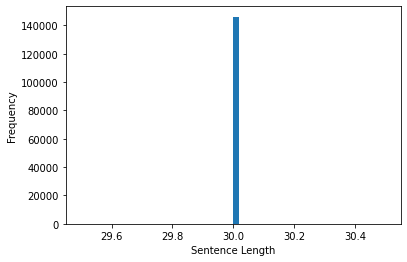

In [8]:
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.sequence import pad_sequences

# 문장 길이 분포 확인
def plot_sentence_length_distribution(X_train):
    sentence_lengths = [len(sentence) for sentence in X_train]
    plt.hist(sentence_lengths, bins=50)
    plt.xlabel('Sentence Length')
    plt.ylabel('Frequency')
    plt.show()

# 패딩 추가
def pad_sequences_custom(X_train, X_test, maxlen=30):
    X_train_padded = pad_sequences(X_train, maxlen=maxlen, padding='post')
    X_test_padded = pad_sequences(X_test, maxlen=maxlen, padding='post')
    return X_train_padded, X_test_padded

# 문장 길이 분포 시각화
plot_sentence_length_distribution(X_train)

# 적절한 문장 길이로 패딩 추가
X_train_padded, X_test_padded = pad_sequences_custom(X_train, X_test, maxlen=30)

## 모델 구성 및 validation set 구성
LSTM, CNN, RNN 모델 사용

### LSTM 모델

In [9]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Conv1D, GlobalMaxPooling1D

# 간단한 LSTM 모델 구성
def build_lstm_model(vocab_size, embedding_dim=128, input_length=30):
    model = Sequential()
    model.add(Embedding(vocab_size, embedding_dim, input_length=input_length))
    model.add(LSTM(64))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

# 단어 사전 크기
vocab_size = len(word_to_index)

# 모델 생성 및 학습
model = build_lstm_model(vocab_size)
history = model.fit(X_train_padded, y_train, epochs=10, validation_data=(X_test_padded, y_test))

Epoch 1/10
4569/4569 [==============================] - 26s 5ms/step - loss: 0.3601 - accuracy: 0.8398 - val_loss: 0.3212 - val_accuracy: 0.8591
Epoch 2/10
4569/4569 [==============================] - 22s 5ms/step - loss: 0.2790 - accuracy: 0.8818 - val_loss: 0.3121 - val_accuracy: 0.8669
Epoch 3/10
4569/4569 [==============================] - 22s 5ms/step - loss: 0.2366 - accuracy: 0.9016 - val_loss: 0.3201 - val_accuracy: 0.8672
Epoch 4/10
4569/4569 [==============================] - 22s 5ms/step - loss: 0.1983 - accuracy: 0.9196 - val_loss: 0.3494 - val_accuracy: 0.8623
Epoch 5/10
4569/4569 [==============================] - 22s 5ms/step - loss: 0.1638 - accuracy: 0.9347 - val_loss: 0.3742 - val_accuracy: 0.8583
Epoch 6/10
4569/4569 [==============================] - 22s 5ms/step - loss: 0.1333 - accuracy: 0.9479 - val_loss: 0.4314 - val_accuracy: 0.8544
Epoch 7/10
4569/4569 [==============================] - 22s 5ms/step - loss: 0.1072 - accuracy: 0.9590 - val_loss: 0.4819 - val_ac

### 1-D CNN 모델

In [10]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Conv1D, GlobalMaxPooling1D, Dense

# 간단한 1-D CNN 모델 구성
def build_cnn_model(vocab_size, embedding_dim=128, input_length=30):
    model = Sequential()
    model.add(Embedding(vocab_size, embedding_dim, input_length=input_length))
    model.add(Conv1D(128, 5, activation='relu'))  # 1D Conv Layer (필터 크기 5)
    model.add(GlobalMaxPooling1D())  # Global Max Pooling Layer
    model.add(Dense(1, activation='sigmoid'))  # 이진 분류를 위한 Dense Layer
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

# 모델 생성 및 학습
model = build_cnn_model(vocab_size)
history = model.fit(X_train_padded, y_train, epochs=10, validation_data=(X_test_padded, y_test))

Epoch 1/10
4569/4569 [==============================] - 21s 4ms/step - loss: 0.3569 - accuracy: 0.8420 - val_loss: 0.3290 - val_accuracy: 0.8582
Epoch 2/10
4569/4569 [==============================] - 18s 4ms/step - loss: 0.2586 - accuracy: 0.8942 - val_loss: 0.3269 - val_accuracy: 0.8622
Epoch 3/10
4569/4569 [==============================] - 18s 4ms/step - loss: 0.1818 - accuracy: 0.9300 - val_loss: 0.3734 - val_accuracy: 0.8557
Epoch 4/10
4569/4569 [==============================] - 18s 4ms/step - loss: 0.1145 - accuracy: 0.9589 - val_loss: 0.4511 - val_accuracy: 0.8487
Epoch 5/10
4569/4569 [==============================] - 18s 4ms/step - loss: 0.0711 - accuracy: 0.9761 - val_loss: 0.5551 - val_accuracy: 0.8451
Epoch 6/10
4569/4569 [==============================] - 18s 4ms/step - loss: 0.0483 - accuracy: 0.9837 - val_loss: 0.6487 - val_accuracy: 0.8421
Epoch 7/10
4569/4569 [==============================] - 18s 4ms/step - loss: 0.0360 - accuracy: 0.9878 - val_loss: 0.7038 - val_ac

### RNN 모델

In [12]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, SimpleRNN, Dense

# 간단한 RNN 모델 구성
def build_rnn_model(vocab_size, embedding_dim=128, input_length=30):
    model = Sequential()
    model.add(Embedding(vocab_size, embedding_dim, input_length=input_length))
    model.add(SimpleRNN(64))  # Simple RNN Layer
    model.add(Dense(1, activation='sigmoid'))  # 이진 분류를 위한 Dense Layer
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

# 모델 생성 및 학습
model = build_rnn_model(vocab_size)
history = model.fit(X_train_padded, y_train, epochs=10, validation_data=(X_test_padded, y_test))

Epoch 1/10
4569/4569 [==============================] - 120s 26ms/step - loss: 0.3928 - accuracy: 0.8242 - val_loss: 0.3686 - val_accuracy: 0.8387
Epoch 2/10
4569/4569 [==============================] - 118s 26ms/step - loss: 0.3202 - accuracy: 0.8644 - val_loss: 0.3593 - val_accuracy: 0.8441
Epoch 3/10
4569/4569 [==============================] - 118s 26ms/step - loss: 0.2711 - accuracy: 0.8874 - val_loss: 0.3688 - val_accuracy: 0.8362
Epoch 4/10
4569/4569 [==============================] - 118s 26ms/step - loss: 0.2262 - accuracy: 0.9093 - val_loss: 0.4025 - val_accuracy: 0.8411
Epoch 5/10
4569/4569 [==============================] - 119s 26ms/step - loss: 0.1884 - accuracy: 0.9270 - val_loss: 0.4374 - val_accuracy: 0.8353
Epoch 6/10
4569/4569 [==============================] - 118s 26ms/step - loss: 0.1580 - accuracy: 0.9401 - val_loss: 0.4682 - val_accuracy: 0.8275
Epoch 7/10
4569/4569 [==============================] - 118s 26ms/step - loss: 0.1391 - accuracy: 0.9478 - val_loss: 0

## Loss, Accuracy 그래프 시각화

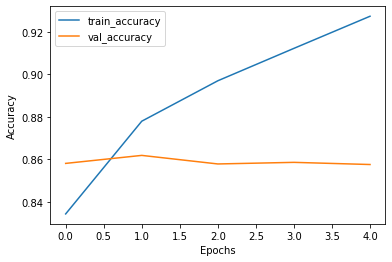

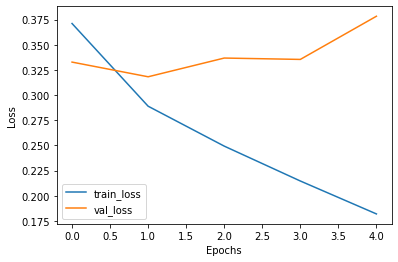

In [35]:
# Loss 및 Accuracy 시각화
def plot_history(history):
    plt.plot(history.history['accuracy'], label='train_accuracy')
    plt.plot(history.history['val_accuracy'], label='val_accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()

    plt.plot(history.history['loss'], label='train_loss')
    plt.plot(history.history['val_loss'], label='val_loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

plot_history(history)

## 학습된 Embedding 레이어 분석

#### 1. 임베딩 가중치 추출

In [14]:
# 임베딩 가중치 추출
# 학습된 Embedding 레이어 가중치 추출
embedding_layer = model.layers[0]
embedding_weights = embedding_layer.get_weights()[0]
print(embedding_weights.shape)  # (vocab_size, embedding_dim)

(10000, 128)


#### 2. 단어 벡터 유사도 측정

In [16]:
# 단어 벡터 유사도 측정
from sklearn.metrics.pairwise import cosine_similarity

def find_similarity(word1, word2, word_to_index, embedding_weights):
    idx1 = word_to_index[word1]
    idx2 = word_to_index[word2]
    vec1 = embedding_weights[idx1].reshape(1, -1)
    vec2 = embedding_weights[idx2].reshape(1, -1)
    return cosine_similarity(vec1, vec2)

# 예시: 두 단어 간의 유사도 계산
similarity = find_similarity('영화', '스파이더맨', word_to_index, embedding_weights)
print(f"영화와 스파이더맨: {similarity[0][0]}")

사랑과 좋아하다의 유사도: 0.030043963342905045


#### 3. 임베딩 시각화

/opt/conda/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/matplotlib/backends/backend_agg.py:240: RuntimeWarning: Glyph 50689 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/opt/conda/lib/python3.9/site-packages/matplotlib/backends/backend_agg.py:240: RuntimeWarning: Glyph 54868 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/opt/conda/lib/python3.9/site-packages/matplotlib/backends/backend_agg.py:240: RuntimeWarning: Glyph 45796 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/opt/conda/lib/python3.9/site-packages/matplotlib/backends/backend_agg.py:240: RuntimeWarning: Glyph 44256 missing from current 

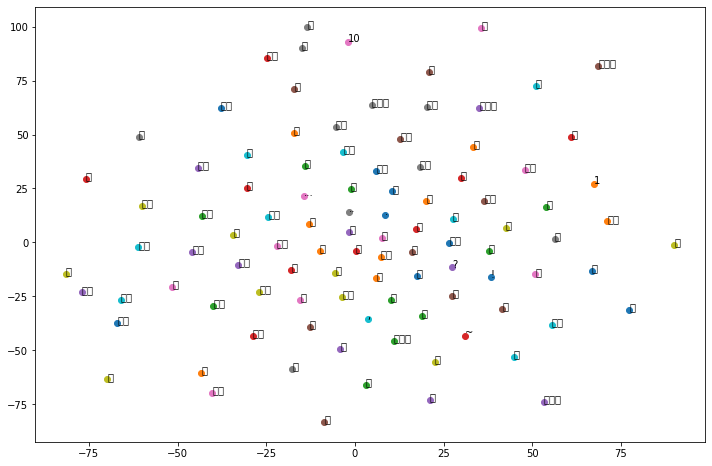

In [17]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

def plot_embedding(vocab_size, embedding_weights, word_to_index, num_words=100):
    words = list(word_to_index.keys())[:num_words]
    vectors = embedding_weights[:num_words]

    tsne = TSNE(n_components=2)
    reduced_vecs = tsne.fit_transform(vectors)

    plt.figure(figsize=(12, 8))
    for i, word in enumerate(words):
        plt.scatter(reduced_vecs[i, 0], reduced_vecs[i, 1])
        plt.annotate(word, (reduced_vecs[i, 0], reduced_vecs[i, 1]))
    plt.show()

# 임베딩 벡터 시각화 (상위 100개 단어)
plot_embedding(vocab_size, embedding_weights, word_to_index)

#### 4. 단어의 가장 유사한 단어 찾기

In [18]:
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np

def most_similar(word, word_to_index, embedding_weights, top_n=5):
    idx = word_to_index[word]
    target_vector = embedding_weights[idx].reshape(1, -1)
    similarities = cosine_similarity(embedding_weights, target_vector).reshape(-1)
    most_similar_idx = np.argsort(-similarities)[:top_n+1]
    most_similar_words = [(list(word_to_index.keys())[i], similarities[i]) for i in most_similar_idx if i != idx]
    return most_similar_words

# 예시: '사랑'과 가장 유사한 단어 5개 찾기
similar_words = most_similar('사랑', word_to_index, embedding_weights)
print(similar_words)

[('.,', 0.7952101), ('성당', 0.7947927), ('특공대', 0.7646754), ('인가', 0.7597705), ('싸웠', 0.7494961)]


## 한국어 Word2Vec 임베딩 활용하여 성능 개선

In [9]:
# Word2Vec 모델 실제 임베딩 차원 확인
embedding_dim = word2vec.vector_size
print("Word2Vec embedding dimension:", embedding_dim)

Word2Vec embedding dimension: 100


Word2Vec embedding dimension: 100
Epoch 1/5
4569/4569 [==============================] - 22s 4ms/step - loss: 0.4478 - accuracy: 0.7885 - val_loss: 0.4041 - val_accuracy: 0.8211
Epoch 2/5
4569/4569 [==============================] - 20s 4ms/step - loss: 0.3768 - accuracy: 0.8320 - val_loss: 0.3779 - val_accuracy: 0.8301
Epoch 3/5
4569/4569 [==============================] - 20s 4ms/step - loss: 0.3498 - accuracy: 0.8458 - val_loss: 0.3746 - val_accuracy: 0.8361
Epoch 4/5
4569/4569 [==============================] - 20s 4ms/step - loss: 0.3313 - accuracy: 0.8548 - val_loss: 0.3666 - val_accuracy: 0.8374
Epoch 5/5
4569/4569 [==============================] - 20s 4ms/step - loss: 0.3163 - accuracy: 0.8619 - val_loss: 0.3585 - val_accuracy: 0.8387


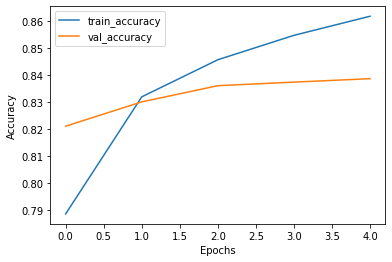

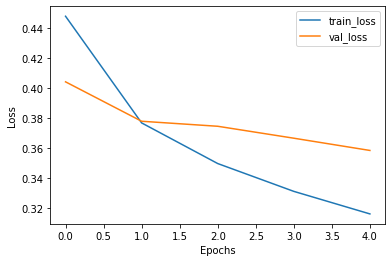

In [10]:
from gensim.models import Word2Vec
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense

# 한국어 Word2Vec 모델 로드
word2vec = Word2Vec.load('/aiffel/data/word2vec_ko.model').wv

# Word2Vec 벡터 차원 확인
embedding_dim = word2vec.vector_size
print("Word2Vec embedding dimension:", embedding_dim)

# Word2Vec 임베딩을 활용한 모델 구성
def build_word2vec_model(vocab_size, embedding_dim, input_length=30, word2vec=None):
    model = Sequential()
    
    # 임베딩 매트릭스 생성
    embedding_matrix = np.zeros((vocab_size, embedding_dim))
    
    for word, i in word_to_index.items():
        if word in word2vec:
            embedding_matrix[i] = word2vec[word]
    
    # Embedding Layer 추가
    model.add(Embedding(vocab_size, embedding_dim, input_length=input_length, weights=[embedding_matrix], trainable=False))
    
    # LSTM 레이어 추가
    model.add(LSTM(64))
    
    # Dense 레이어 추가 (이진 분류)
    model.add(Dense(1, activation='sigmoid'))
    
    # 모델 컴파일
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    
    return model

# Word2Vec을 적용한 모델 생성 및 학습
vocab_size = len(word_to_index)  # 단어 사전 크기
model = build_word2vec_model(vocab_size, embedding_dim, word2vec=word2vec)
history = model.fit(X_train_padded, y_train, epochs=5, validation_data=(X_test_padded, y_test))

# 학습 성능 시각화
plot_history(history)

### ROC 커브 계산하여 성능변화 시각화하기

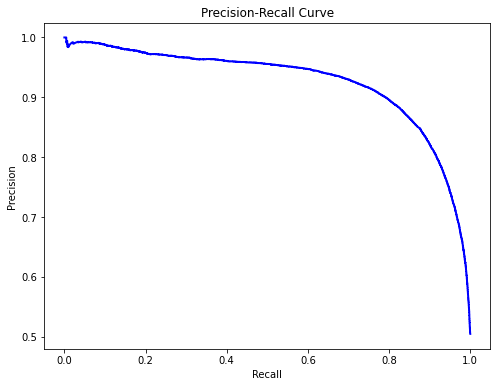

In [65]:
from sklearn.metrics import precision_recall_curve

# 예측 확률값 얻기
y_pred_prob = model.predict(X_test_padded).ravel()

# Precision-Recall Curve 계산
precision, recall, thresholds = precision_recall_curve(y_test, y_pred_prob)

# Precision-Recall Curve 시각화
plt.figure(figsize=(8, 6))
plt.plot(recall, precision, color='b', lw=2)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.show()

### 워드클라우드로 부정, 긍정 리뷰 시각화하기

In [64]:
from wordcloud import WordCloud

def plot_wordcloud(data, label, word_to_index):
    text_data = [" ".join([list(word_to_index.keys())[idx] for idx in sentence]) for sentence in data]
    text = " ".join(text_data)
    
    wordcloud = WordCloud(width=200, height=100, background_color='white').generate(text)
    
    plt.figure(figsize=(10, 6))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(f'Word Cloud for {label} Data')
    plt.show()

# Negative 클래스에 속하는 텍스트의 Word Cloud 생성
plot_wordcloud(X_train_padded[y_train == 0], 'Negative', word_to_index)

# Positive 클래스에 속하는 텍스트의 Word Cloud 생성
plot_wordcloud(X_train_padded[y_train == 1], 'Positive', word_to_index)

KeyboardInterrupt: 

### 회고
NLP 부분은 관심이 많았지만 공부를 해보지 않았어서 어려웠다. 하지만 텍스트 분류와 토큰으로 단어를 임베딩하고 인코더 디코더하는 부분은 굉장히 흥미로웠다. 어렵기도 하고 이해가 안되는 부분이 많았지만 열심히 더 공부하고 노력하다 보면, 하고 싶은 프로젝트에 많이 기여할 수 있고 도움이 될 것 같아서 좋았다.